05 .Species Diversity 
=====================  
**Species diversity is the number of different species that are represented in a given community (a dataset).** 

In this analysis we are going to use the DivNet R package (https://github.com/adw96/DivNet). DivNet's about:  
*If you knew the exact composition of a community (such as all of the microbes living on your skin), you could calculate the Shannon diversity of the community, or the Bray-Curtis distance between your skin's microbes and your cat's fur microbes. However, you will only ever observe a small fraction of the microbes on your skin from your experiment, so you have to estimate these diversity indices based on the data, and ideally you will get a confidence interval for those diversity indices.  

*Almost all ecologists use "plug-in" diversity estimates, obtained by taking the observed relative abundances of each taxon and plugging them into the formula for the true diversity. This is problematic for a number of reasons, including that there may be unobserved taxa, and the observed relative abundances probably don't exactly equal the true relative abundances due to random sampling. Furthermore, typical approaches to obtaining a confidence interval assume that all taxa behave independently: if taxon A is there, this tells you nothing about whether taxon B is likely to be there too. DivNet takes care of all of these issues, and gives you a confidence interval that incorporates all of these challenges.

In [2]:
library(phyloseq)
library(breakaway)
library(DivNet)

In [5]:
#rds <- readRDS("../../../../../data//tmp/microbiome/quant/qiime2/silva/physeq.rds")


In [2]:
rds <- readRDS(snakemake@input[[1]])

In [ ]:

df <- data.frame(as(sample_data(rds), "matrix"))

group <- factor(df[,snakemake@params$condition])
if (!is.null(snakemake@params$ref_level)){
    group <- relevel(group, ref=snakemake@params$ref_level)
    df[,"Sample_Group"] <- group
    sample_data(rds) <- df
    }
batch <- NULL
if (!is.null(snakemake@params$batch)){
    batch <- factor(snakemake@params$batch)
    df[,snakemake@params$batch] <- batch
    sample_data(rds) <- df
}

subset <- NULL
if (!is.null(snakemake@params$subset)){
    if (grepl("::", snakemake@params$subset)){
        els <- unlist(strsplit(snakemake@params$subset, "::"))
        keep <- df[,els[1]] == els[2]
    } else{
        subset <- unlist(strsplit(snakemake@params$subset, ","))
        keep <- sample_names(rds) %in% subset 
    }
    rds <- prune_samples(keep, rds)
}


In [5]:
rds <- subset_taxa(rds,
    Kingdom == "Bacteria" &
    Family  != "mitochondria" &
    Class   != "Chloroplast" &
    Phylum != "Cyanobacteria/Chloroplast"
  )
rds = prune_taxa(taxa_sums(rds) > 0, rds)



Next step is to agglomerate at a specific taxon level 

In [15]:
if (!is.null(snakemake@params$taxrank)){
    cat("Taxrank: ", snakemake@params$taxrank, "\n")
    if (require(speedyseq)){
        rds <- speedyseq::tax_glom(rds, taxrank=snakemake@params$taxrank)
    } else{
        rds <- tax_glom(rds, taxrank=snakemake@params$taxrank)
    } 
} else{
    cat("Taxrank: None, Data is not aggregated. Each feature is an ASV (specific sequence)", "\n")
}
rds

Taxrank: None, Data is not aggregated. Each feature is an ASV (specific sequence) 


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 821 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 821 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 821 tips and 814 internal nodes ]
refseq()      DNAStringSet:      [ 821 reference sequences ]

**DivNet Analaysis**

In [13]:
div_tax <-  divnet(rds, X=NULL, ncores=snakemake@threads)
div_tax_X <-  divnet(rds, X="Sample_Group", ncores=snakemake@threads)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [9]:
tab <- testDiversity(div_tax_X)

Hypothesis testing:


ERROR: Error in isTRUE(is.na(X)): object 'divnet_tax_X' not found


In [8]:
library(magrittr)
library(ggplot2)

First we show the traditional way, with estimates per sample (but now with error bars!)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



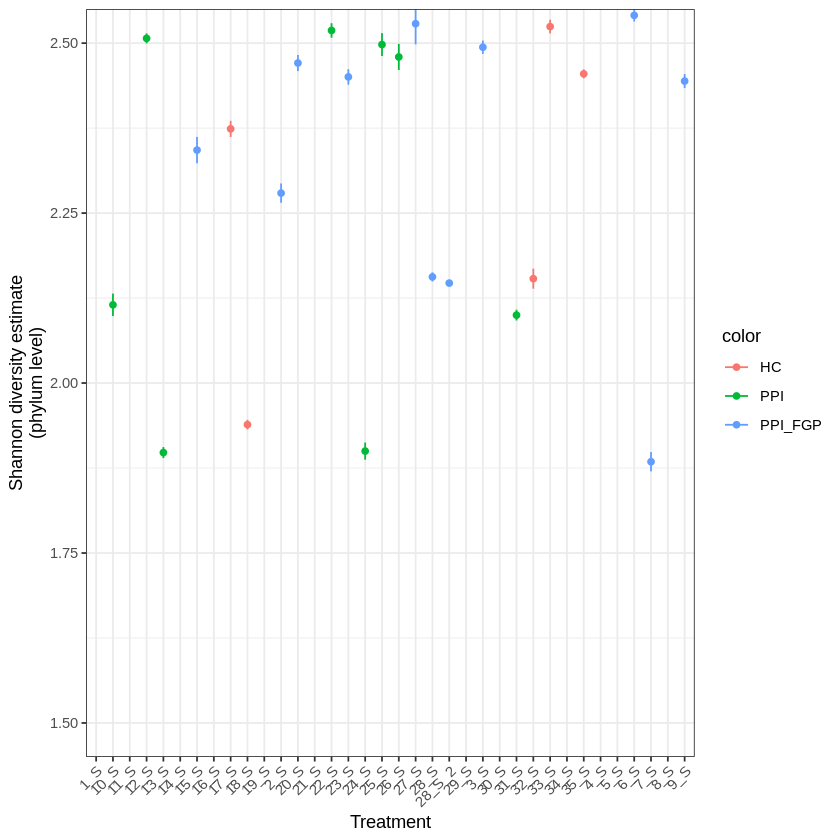

In [15]:
div_tax$shannon %>% 
  plot(rds, color = "Sample_Group") +
  xlab("Treatment") +
  ylab("Shannon diversity estimate") +
  coord_cartesian(ylim = c(1.5,2.5))

Now for the DivNet way of directly doing estimates on the covariates. Now each sample within a group covariate will have a mean and error estimate.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



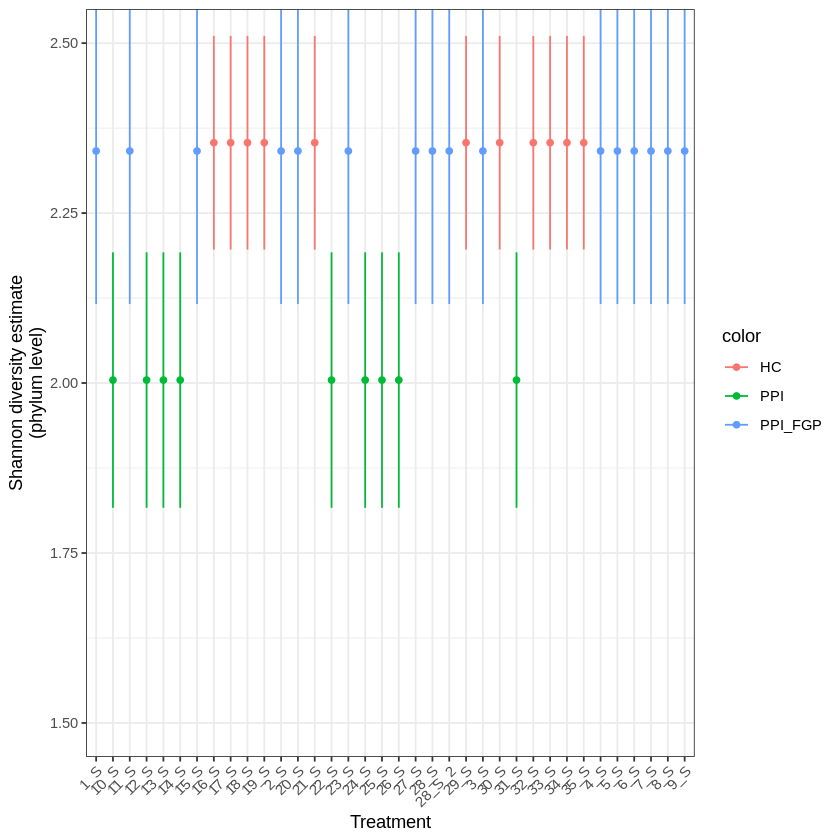

In [16]:
div_tax_X$shannon %>% 
  plot(rds, color = "Sample_Group") +
  xlab("Treatment") +
  ylab("Shannon diversity estimate") +
  coord_cartesian(ylim = c(1.5,2.5))

We can do a significance test of the covariates:

In [2]:
#estimates <- div_tax$shannon %>% summary %$% estimate
#ses <- sqrt(div_tax$`shannon-variance`)
#X <- breakaway::make_design_matrix(rds, "Sample_Group")
#res <- betta(estimates, ses, X)
#res$table

In [21]:
estimates <- div_tax_X$shannon %>% summary %$% estimate
ses <- sqrt(div_tax_X$`shannon-variance`)
X <- breakaway::make_design_matrix(rds, "Sample_Group")
resX <- betta(estimates, ses, X)
resX$table

,Estimates,Standard Errors,p-values
(Intercept),2.35353153,0.01568467,0.000
predictorsPPI,-0.34915718,0.03131398,0.000
predictorsPPI_FGP,-0.01222127,0.02814354,0.664


In [ ]:
write.table(resX$table, file=snakemake@output[[1]], sep="\t")

In [3]:

cat("Wrote signficance test results:", snakemake@output[[1]])

ERROR: Error in cat("Wrote signficance test results:", snakemake@output[[1]]): object 'snakemake' not found
